In [26]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import sklearn.utils as u 
import sklearn.ensemble as e
import sklearn.cross_validation as c_v
import sklearn.neighbors as nb
import sklearn.grid_search as gs

In [14]:
def make_flat(inp,smooth = (299,299),al =1):
    inp = inp.astype(int)
    sm =cv2.GaussianBlur(inp.astype(np.uint8), smooth, 0)
    fl = inp - al*sm.astype(int) 
    fl = fl - np.amin(fl)
    fl = fl*250/np.amax(fl)
    return fl.astype(np.uint8)

def shell_via_zeros(small, shape):
    target= np.zeros(shape)
    siz = small.shape
    coor = [int(shape[i]/2 - siz[i]/2) for i in [0,1]]
    target[coor[0]:coor[0]+siz[0],coor[1]:coor[1]+siz[1]] = small
    return target

def scale_fit_rect(inp,shape):
    
    siz = inp.shape
    al = float(shape[0])/max(siz)
    inp = inp.astype(np.uint8)
    res = cv2.resize(inp,None,fx = al,fy = al)
    target= np.zeros(shape)
    siz= res.shape
    coor = [int(shape[i]/2 - siz[i]/2) for i in [0,1]]
    target[coor[0]:coor[0]+siz[0],coor[1]:coor[1]+siz[1]] = res
    return target.astype(int)
def display(inp,interp="nearest",bins=32):
    fig,ax = plt.subplots(1,2,figsize  = (13,4))
    cax = ax[1].imshow(inp,interpolation=interp,cmap='Greys_r')
    fig.colorbar(cax)
    ax[0].hist(inp.ravel(), bins=bins)

# Processing an aligned image using rects and scale to (25,25)

In [18]:
img = cv2.imread("myhand.png")
im=img.mean(2)
im_gray =cv2.GaussianBlur(im, (5, 5), 0)
im_gray = im_gray.astype(np.uint8)
#threshhold
ret, im_th = cv2.threshold(im_gray, (im_gray.mean()-20), 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("hand-1.png",im_th)
# Find contours in the image
ctrs, hier = cv2.findContours(im_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
for rect in rects:
    cv2.rectangle(img, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 

cv2.imwrite("hand-2.png",img)

True

In [19]:
rects = np.asarray(rects)
rectss = [(rects[(rects[:,1]<i+25)&(rects[:,1]>i)]) for i  in np.arange(0,550,25)]
rectss = [a[a[:,0].argsort(axis=0)]for a in rectss]
rectss = [rectss[i][rectss[i][:,3]>5] for i in np.arange(0,22)]
rectss = np.asarray(rectss).reshape(220,4)

In [20]:
digs = np.asarray([im[v[1]:v[1]+v[3],v[0]:v[0]+v[2]] for v in rectss])
digs_n = 33 - digs/8.0
shelled = [scale_fit_rect(v,(25,25)) for v in digs_n ]
X_sh = np.asarray(shelled).reshape(220,625)

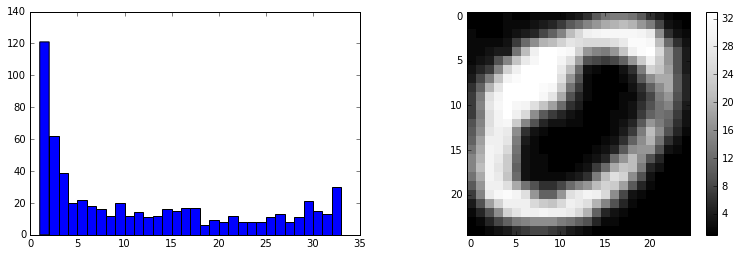

In [21]:

    
display(shelled[10].astype(int))

0.82738095238095244

## Learning from custom image

In [9]:
img_cus = cv2.imread('learn_im.jpg')

im_cus = img_cus.mean(2).astype(np.uint8)
im_cus_pr = make_flat(cv2.GaussianBlur(im_cus,(7,7),0))
ret, im_cust = cv2.threshold(im_cus_pr, (im_cus_pr.mean()-60), 255, cv2.THRESH_BINARY_INV)

# Find contours in the image
ctrs, hier = cv2.findContours(im_cust.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
rects = [cv2.boundingRect(ctr) for ctr in ctrs]
for rect in rects:
    cv2.rectangle(img_cus, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 
cv2.imwrite('learn-0.png',img_cus)

True

In [11]:
rects= np.asarray(rects)
rectss= []
sizes = np.sqrt(rects[:,2]*rects[:,3])
###      cutting small rects
#plt.hist(sizes,bins = 10)
rects = rects[sizes>10] # !_90 Works inly for this image
print rects.shape
ind = rects[np.argmin(rects[:,0]+rects[:,1])]

recind = rects[rects[:,0]<ind[0]+ind[2]]
inds = recind[np.argsort(recind[:,1])]
re = rects

for ind in inds:

    recind = re[re[:,1]<ind[1]+ind[3]]
    rectss.append(recind[np.argsort(recind[:,0])])
    
    re = np.array(list(set(tuple(x) for x in re.tolist()).difference(set(tuple(x) for x in recind.tolist()))))
rectss=np.asarray(rectss)
rectss =  rectss.reshape(rectss.shape[0]*10,4)
l = rectss.shape[0]
y_cus = np.asarray([np.arange(10) for i in np.arange(l/10)]).reshape(l)
i=0
for rect in rectss:
    cv2.putText(img_cus, str(int(y_cus[i])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 1)
    i=i+1
cv2.imwrite('learn-0.png',im_cus)


(140L, 4L)


True

(140L, 625L) (140L,)


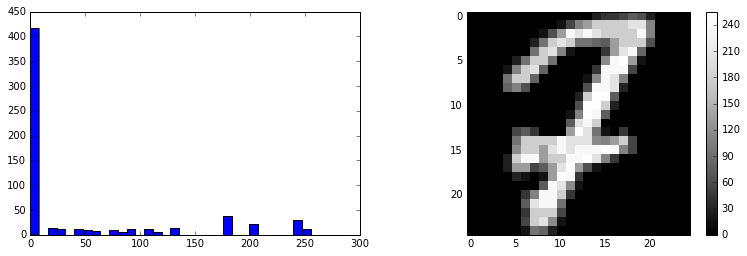

In [15]:
X_cus =(33 -np.asarray([im_cus[v[1]:v[1]+v[3],v[0]:v[0]+v[2]] for v in rectss])/8)
X_cus = np.asarray([scale_fit_rect(v,(25,25)) for v in X_cus]).astype(np.uint8)
X_cus = np.asarray([cv2.threshold(X_cus[i],10, 32, 3)[1] for i in np.arange(l)])
X_cus = np.asarray([cv2.equalizeHist(v) for v in X_cus])
display(X_cus[27])
X_cus = X_cus.reshape(l,625)
print X_cus.shape,y_cus.shape    

In [320]:
c_v.cross_val_score(neig,X_cus,y_cus,cv=10).mean()

0.94000000000000006

# Processing custom image and predicting
### 1: using Gradient Boosting

In [54]:
forest = e.GradientBoostingClassifier(max_features=25,n_estimators=40)
y = np.asarray([np.arange(0,10) for i in np.arange(0,22)]).reshape(220)
forest.fit(X_sh,y)
print X_cus.shape, X_sh.shape

neig = nb.KNeighborsClassifier()
neig.fit(np.vstack((X_cus,X_sh)),np.hstack((y_cus,y)))

#c_v.cross_val_score(nei,X_sh,y,cv=3).mean()


(140L, 625L) (220L, 625L)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [87]:
tst = cv2.imread("test.jpg")
im_t = tst.mean(2)
im_t = im_t.astype(np.uint8)
#im  = cv2.equalizeHist(im)
im_gray =cv2.GaussianBlur(im_t, (19, 19), 0)
im_gray = make_flat(im_gray,smooth =(101,101))
# Threshold the image
ret, tst_th = cv2.threshold(im_gray, 125, 255, cv2.THRESH_BINARY_INV)
cv2.imwrite("test-1.png",tst_th)
ctrs, hier = cv2.findContours(tst_th.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rects_t = np.asarray([cv2.boundingRect(ctr) for ctr in ctrs])
for rect in rects_t:
    cv2.rectangle(tst, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 1) 
#cv2.imwrite("test-2.png",tst)

In [88]:
test = np.asarray([cv2.equalizeHist(im_t[v[1]:v[1]+v[3],v[0]:v[0]+v[2]]) for v in rects_t])
test_n = 32  - test/8
l =  test.shape[0]
test_n = np.asarray([cv2.threshold(test_n[i], 12, 32, 3)[1] for i in np.arange(l)])
test_n = np.asarray([cv2.equalizeHist(v) for v in test_n])
X_tst = np.asarray([scale_fit_rect(v,(25,25))for v in test_n])

X_tst = np.asarray(X_tst).reshape(rects_t.shape[0],625)
X_tst = X_tst.astype(int)


#### predicting

(367L, 625L) 18 324


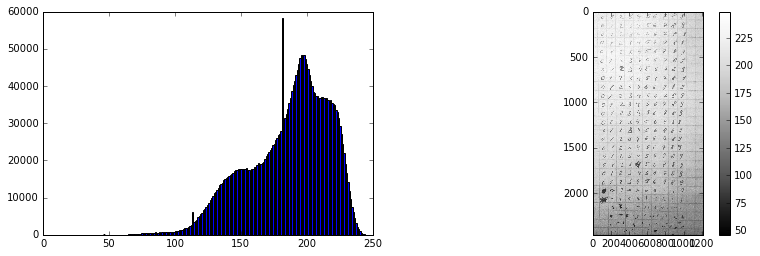

In [89]:
#probs = [max(forest.predict_proba(X_tst)[i]) for i in np.arange(0,l)]
#preds = forest.predict(X_tst)
#result = preds[probs>0.01]
n=18
al =0.75
print X_tst.shape,int(25*al),pow(int(25*al),2)
#display(cv2.resize(X_tst[n].reshape(25,25).astype(np.uint8),None,fx=al,fy=al)) 
pred = neig.predict(X_tst)
i=0
for rect  in rects_t:
    cv2.putText(tst, str(int(pred[i])), (rect[0], rect[1]),cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 255), 1)
    i=i+1
cv2.imwrite('test-2.png',tst)
display(im_t,bins = 200)

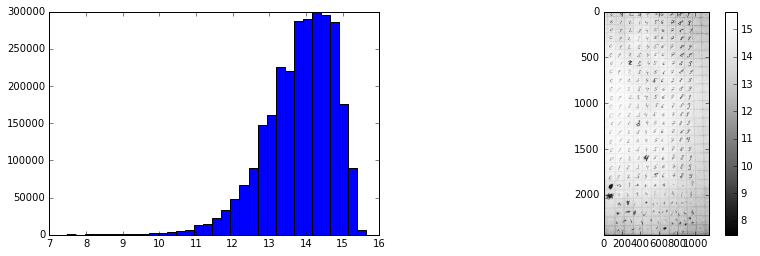

In [71]:
display(np.sqrt((im_t)),bins=33)

### 2: using Nearest Neighbour and gridsearching for best params

In [32]:

params = {'metric' :['euclidean','braycurtis'],'n_neighbors':[1,3,4,5,6],
         'weights':['uniform','distance']}

neig = nb.KNeighborsClassifier()
search_cv1 = []
X_shuf,y_shuf = u.shuffle(X_cus,y_cus)
for i in np.arange(3,13):
    search = gs.GridSearchCV(neig,params,cv=i)
    %time search.fit(X_shuf,y_shuf)
    search_cv1.append(search.best_score_)
    print i,": ", search.best_score_,search.best_params_
search.grid_scores_
plt.plot(np.arange(3,13),search_cv1)

Wall time: 2.85 s
3 :  0.957142857143 {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'}
Wall time: 2.79 s
4 :  0.964285714286 {'n_neighbors': 1, 'metric': 'euclidean', 'weights': 'uniform'}


KeyboardInterrupt: 

In [ ]:
plt.plot(np.arange(3,13),search_cv1        )

In [1747]:

X = np.asarray([[im[i:i+25,j:j+25]for j in np.arange(0,250,25)]for i in np.arange(0,550,25)])
X  = X.reshape(10,22,625)
X = 32 - X/8
X=  X.astype(int)
X = X.reshape(220,625)
y = np.asarray([np.arange(0,10) for i in np.arange(0,22)]).reshape(220)
print X.shape,y.shape

(220L, 625L) (220L,)


In [1748]:
stack = np.array([X_tst[57]])# !Carefull!
y_st = np.array([5])
print stack.shape,y_st.shape

IndexError: index 57 is out of bounds for axis 0 with size 31

In [1168]:
stack = np.vstack((stack, X_tst[n]))
y_st  = np.append(y_st,3)
print stack.shape,y_st.shape


(9L, 625L) (9L,)


9


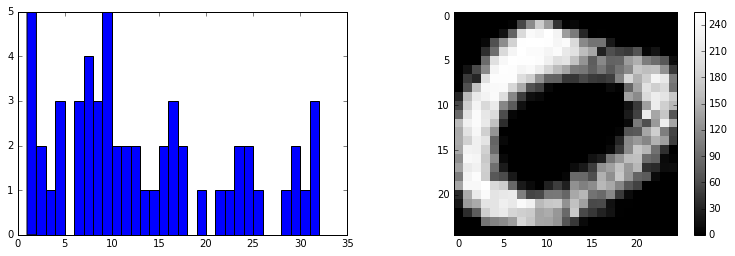

In [1817]:
display(stack[7].reshape(25,25))
print y_st[3]

In [45]:

print stack.shape
X_sh_th = np.asarray(X_sh).astype(np.uint8)
X_sh_th = np.asarray([cv2.equalizeHist( cv2.threshold(v, 3, 32, 3)[1]) for v in X_sh_th ])

X_sh_th =  X_sh_th.reshape(220,625)

data = np.vstack((X_sh_th,stack))
keys = np.append(y,y_st)
ae = data[27].reshape(25,25).astype(np.uint8)
display(cv2.resize(ae,None,fx =0.7,fy =0.7))
print keys[27]


NameError: name 'stack' is not defined

In [1663]:
# write data for hand, Carefull!
pd.DataFrame(data).to_csv('data_hand.csv')

# Configuring params for preparing for Threshhold

In [1878]:
tst = cv2.imread("testt-2.jpg")
im_t = tst.mean(2)
im_t = im_t.astype(np.uint8)
#im  = cv2.equalizeHist(im)
im_gray_sm = []
im_gray_sm =cv2.GaussianBlur(im_t, (299, 299), 0)

cv2.imwrite("test-0.png",im_gray_sm)
    


True

True

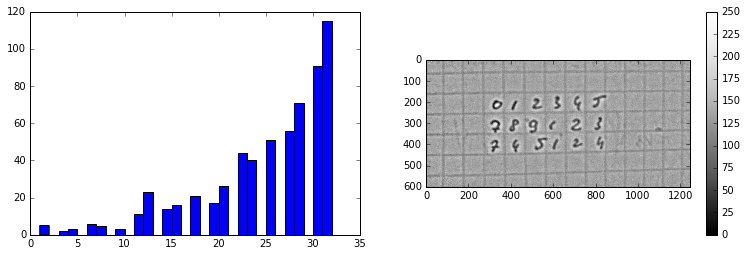

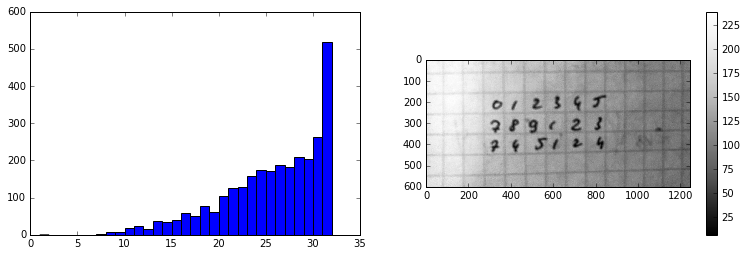

In [1954]:

im_s = cv2.GaussianBlur(im_t, (3, 3), 0)
#flated= im_s -0.5*im_gray_sm*(1/(np.log(25.5))*np.log((-np.abs(im_s-im_gray_sm)+(255.) +1/0.1 -5. )*0.1))
#display(make_flat(hey,smooth=(501,501)))
flated= im_s -0.8*im_gray_sm
flated = flated + abs(np.amin(flated))
hey = make_flat(im_s,smooth=(67,67))
display(hey)
display(im_s)
cv2.imwrite("test-2.png",im_s)
cv2.imwrite("test-4.png",cv2.GaussianBlur(hey,(17,17),0))

In [1495]:
np.exp(-0.03*(1))

0.97044553354850815

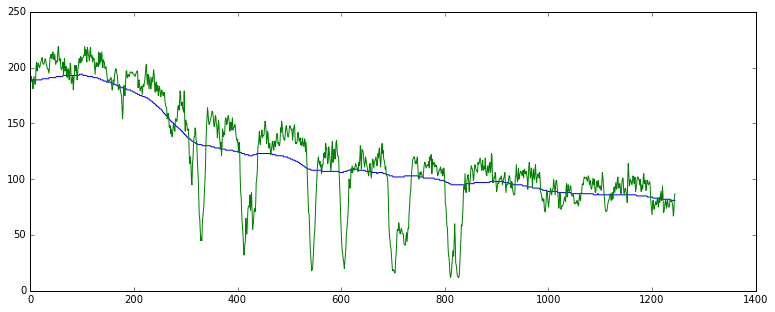

In [1931]:
r = cv2.imread("testt-2.jpg")
r = r.mean(2).astype(np.uint8)
r_smooth = cv2.GaussianBlur(r,(255,255),0)
y =r[400]
s = r_smooth[400]
x = np.arange(r.shape[1])

plt.figure(figsize=(13,5))
plt.plot(x,s)
plt.plot(x,y)

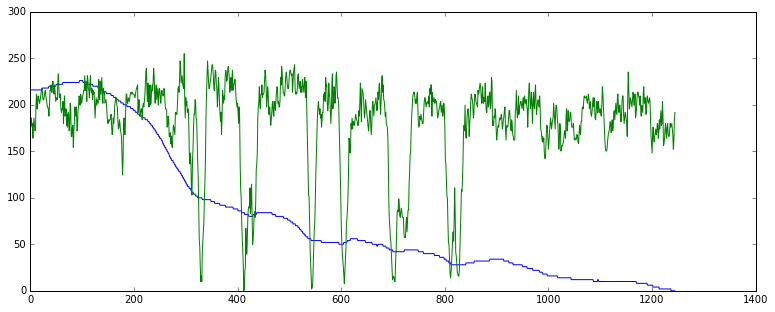

In [1932]:
plt.figure(figsize=(13,5))
s= s.astype(int)
y = y.astype(int)

tr = y-s
tr = tr +abs(np.amin(tr))
tr=tr.astype(np.uint8)
#plt.plot(x,tr)

sm =(s - np.amin(s))
sm = (sm)*(255/np.amax(sm)) 
plt.plot(x,sm)
slop = 0.4
al= 1
fl =(tr - np.amin(tr))
fl = (fl)*(255./np.amax(fl)) 
plt.plot(x,fl)